In [275]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd
import geodatasets

In [276]:
# load in our dataset:
# https://www.kaggle.com/datasets/nelgiriyewithana/global-weather-repository/code

df = pd.read_csv('GlobalWeatherRepository.csv')
df.head()

,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,Afghanistan,Kabul,34.52,69.18,Asia/Kabul,1715849100,2024-05-16 13:15,26.6,79.8,Partly Cloudy,...,8.4,26.6,1,1,04:50 AM,06:50 PM,12:12 PM,01:11 AM,Waxing Gibbous,55
1,Albania,Tirana,41.33,19.82,Europe/Tirane,1715849100,2024-05-16 10:45,19.0,66.2,Partly cloudy,...,1.1,2.0,1,1,05:21 AM,07:54 PM,12:58 PM,02:14 AM,Waxing Gibbous,55
2,Algeria,Algiers,36.76,3.05,Africa/Algiers,1715849100,2024-05-16 09:45,23.0,73.4,Sunny,...,10.4,18.4,1,1,05:40 AM,07:50 PM,01:15 PM,02:14 AM,Waxing Gibbous,55
3,Andorra,Andorra La Vella,42.50,1.52,Europe/Andorra,1715849100,2024-05-16 10:45,6.3,43.3,Light drizzle,...,0.7,0.9,1,1,06:31 AM,09:11 PM,02:12 PM,03:31 AM,Waxing Gibbous,55
4,Angola,Luanda,-8.84,13.23,Africa/Luanda,1715849100,2024-05-16 09:45,26.0,78.8,Partly cloudy,...,183.4,262.3,5,10,06:12 AM,05:55 PM,01:17 PM,12:38 AM,Waxing Gibbous,55


In [277]:
#data cleaning and preprocessing
df.dtypes
df.shape
df.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
latitude,57880.0,1.913623e+01,2.447707e+01,-4.130000e+01,3.750000e+00,1.725000e+01,4.040000e+01,6.415000e+01
longitude,57880.0,2.218549e+01,6.581125e+01,-1.752000e+02,-6.836100e+00,2.332000e+01,5.058000e+01,1.792200e+02
last_updated_epoch,57880.0,1.728748e+09,7.479971e+06,1.715849e+09,1.722343e+09,1.728812e+09,1.735209e+09,1.741600e+09
temperature_celsius,57880.0,2.224184e+01,9.634032e+00,-2.490000e+01,1.700000e+01,2.500000e+01,2.850000e+01,4.920000e+01
temperature_fahrenheit,57880.0,7.203693e+01,1.734105e+01,-1.280000e+01,6.260000e+01,7.700000e+01,8.330000e+01,1.206000e+02


In [278]:
# --- Data Cleaning & Preprocessing ---
df['last_updated'] = pd.to_datetime(df['last_updated'])

# Drop redundant columns
drop_cols = ['temperature_fahrenheit', 'feels_like_fahrenheit', 'pressure_in', 'precip_in', 
             'visibility_miles', 'wind_mph', 'gust_mph']
df.drop(columns=drop_cols, inplace=True)

In [279]:
# Handle outliers
def clean_outliers(col, threshold):
    median = df[col].median()
    df[col] = df[col].apply(lambda x: x if x < threshold else median)
    
clean_outliers("wind_kph", 200)
clean_outliers("gust_kph", 200)

# Handle invalid air quality values
air_quality_cols = ['air_quality_Carbon_Monoxide', 'air_quality_PM10', 'air_quality_Sulphur_dioxide']
for col in air_quality_cols:
    df[col] = df[col].apply(lambda x: x if x > 0 else None)

# Normalize relevant columns
scaler = MinMaxScaler()
norm_cols = ["temperature_celsius", "humidity", "wind_kph", "pressure_mb", "precip_mm", 
             "air_quality_PM2.5", "air_quality_PM10"]
df[norm_cols] = scaler.fit_transform(df[norm_cols])

# Set time-based index
df.set_index("last_updated", inplace=True)


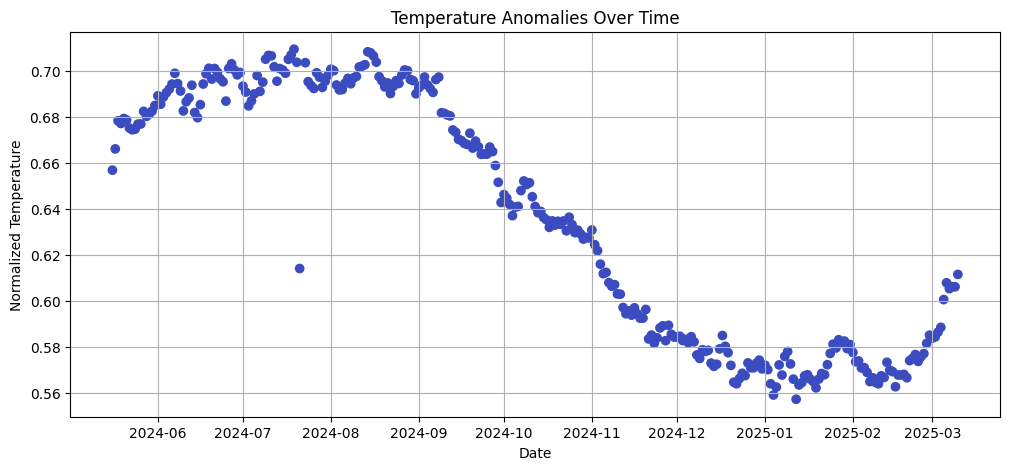

In [280]:
# --- Exploratory Data Analysis (EDA) ---
weather_daily = df.select_dtypes(include=['number']).resample('D').mean()

# Drop NaN values before modeling
weather_daily = weather_daily.dropna()

# Anomaly Detection
weather_daily['temperature_anomaly'] = np.abs(weather_daily['temperature_celsius'] - weather_daily['temperature_celsius'].mean()) > 2 * weather_daily['temperature_celsius'].std()
plt.figure(figsize=(12, 5))
plt.scatter(weather_daily.index, weather_daily['temperature_celsius'], c=weather_daily['temperature_anomaly'], cmap='coolwarm')
plt.xlabel("Date")
plt.ylabel("Normalized Temperature")
plt.title("Temperature Anomalies Over Time")
plt.grid(True)
plt.show()

In [281]:
# --- Forecasting with Multiple Models ---
# ARIMA Model
arima_model = ARIMA(weather_daily['temperature_celsius'], order=(5,1,0))
arima_result = arima_model.fit()
forecast_arima = arima_result.forecast(steps=30)

# Random Forest Regressor
X = weather_daily.drop(columns=['temperature_celsius'])
y = weather_daily['temperature_celsius']
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)
pred_rf = rf_model.predict(X)

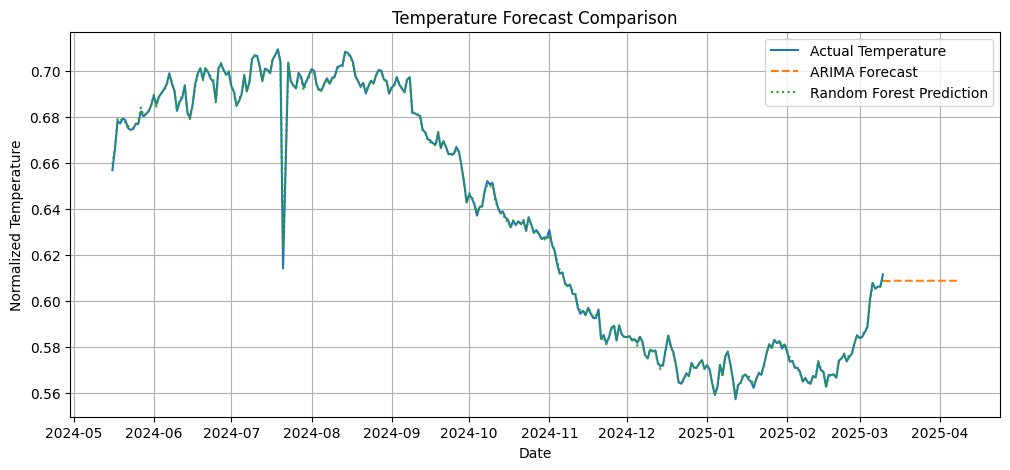

In [282]:
# Compare Forecasts
plt.figure(figsize=(12, 5))
plt.plot(weather_daily.index, weather_daily['temperature_celsius'], label="Actual Temperature")
plt.plot(pd.date_range(weather_daily.index[-1], periods=30, freq='D'), forecast_arima, label="ARIMA Forecast", linestyle='dashed')
plt.plot(weather_daily.index, pred_rf, label="Random Forest Prediction", linestyle='dotted')
plt.xlabel("Date")
plt.ylabel("Normalized Temperature")
plt.title("Temperature Forecast Comparison")
plt.legend()
plt.grid(True)
plt.show()

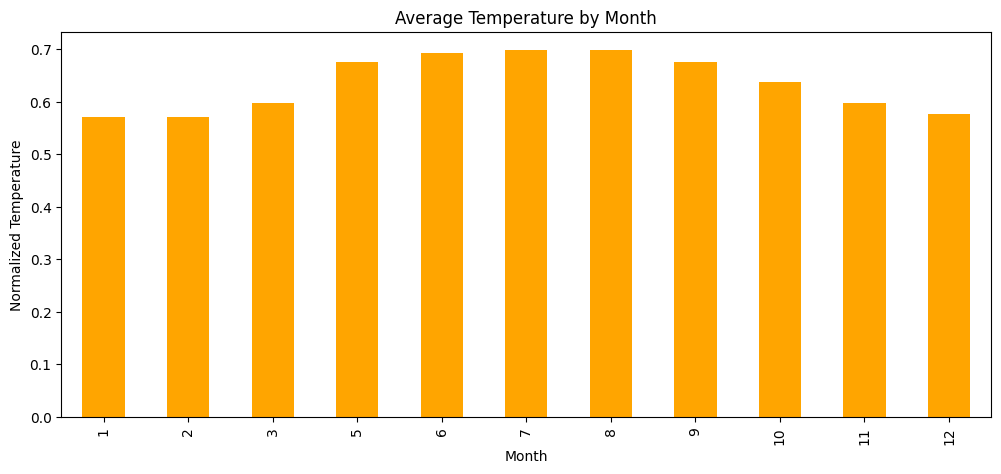

In [283]:
# --- Climate Analysis ---
df.groupby(df.index.month)["temperature_celsius"].mean().plot(kind='bar', figsize=(12,5), color='orange')
plt.title("Average Temperature by Month")
plt.xlabel("Month")
plt.ylabel("Normalized Temperature")
plt.show()

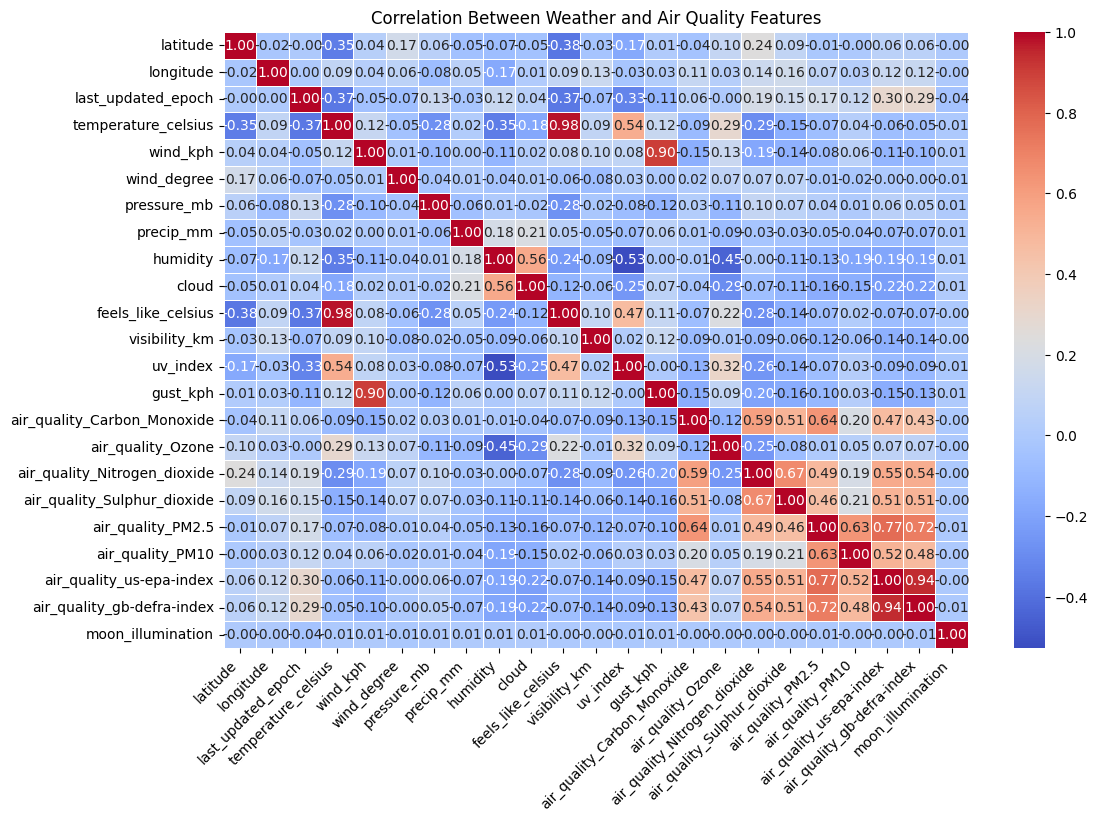

In [284]:
# --- Environmental Impact Analysis ---
plt.figure(figsize=(12,8))
sns.heatmap(df.select_dtypes(include=['number']).corr(), cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title("Correlation Between Weather and Air Quality Features")
plt.title("Correlation Between Weather and Air Quality Features")
plt.show()

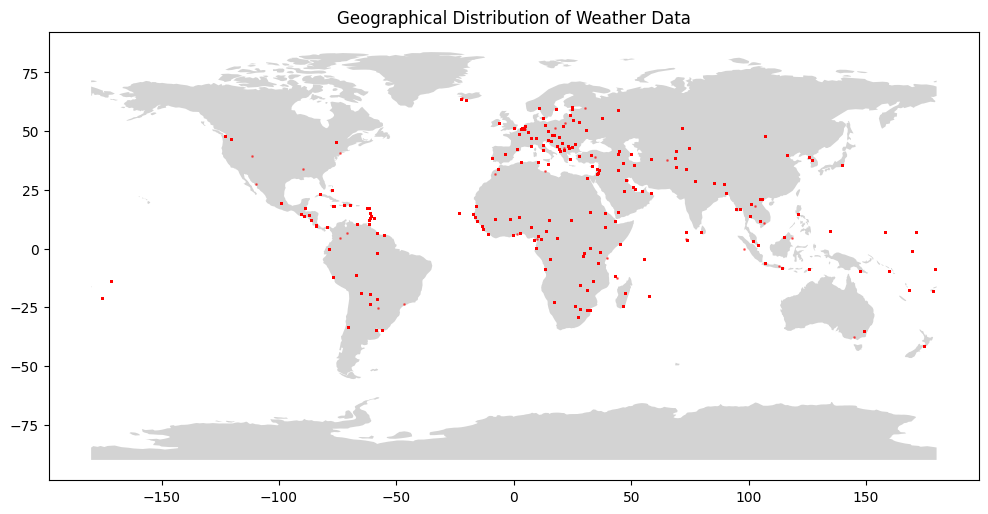

In [285]:
# --- Spatial Analysis ---
geo_df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
world = gpd.read_file(geodatasets.get_path('naturalearth.land'))
fig, ax = plt.subplots(figsize=(12, 6))
world.plot(ax=ax, color='lightgrey')
geo_df.plot(ax=ax, markersize=1, color='red', alpha=0.5)
plt.title("Geographical Distribution of Weather Data")
plt.show()
